### Sample program for clustering of documents with TF-IDF  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### Parameters  

In [2]:
csv_in = 'newsgroups5-2.csv'
min_count = 10
min_words = 50

#### Read CSV file  

In [3]:
df = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())

(2927, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       2927 non-null   object
 1   target        2927 non-null   int64 
 2   target_names  2927 non-null   object
dtypes: int64(1), object(2)
memory usage: 68.7+ KB
None


,content,target,target_names
0,"From article <C5owCB.n3p@world.std.com>, by t...",1,sci.space
1,In article <1r1eu1$4t@transfer.stratus.com> c...,3,talk.politics.guns
2,In article <1993Apr23.184732.1105@aio.jsc.nas...,1,sci.space
3,What is the EXACT entry (parameter and synta...,2,comp.windows.x
4,In article <1993Apr20.151818.4319@samba.oit.u...,0,rec.sport.hockey


#### Delete too short docs  

In [4]:
df = df[ df['content'].map(lambda x: len(x.split())) >= min_words ]
df = df.reset_index(drop=True)
print(df.shape)

(2693, 3)


#### Check the number of documents in each category  

In [5]:
print(df['target'].value_counts())

4    570
1    550
0    543
3    528
2    502
Name: target, dtype: int64


#### Assign docID according to its category  
- docID = 'd' + number, such as d0, d1, ..., d1000, d1001, ...
 - number = target * 1000 + j

In [6]:
docID = []
j = np.zeros(len(df['target'].value_counts()))
for i in range(len(df)):
    tgt = df.at[i, 'target']
    # base of document ID:
    #   0 for documents of target 0, 1000 for documents of target 1,
    #   2000 for documents of target 2, ...
    docID.append('d'+str(int(tgt*1000+j[tgt])))
    # increment j for target "tgt"
    j[tgt] += 1
df['docID'] = docID
display(df.head())

,content,target,target_names,docID
0,"From article <C5owCB.n3p@world.std.com>, by t...",1,sci.space,d1000
1,In article <1r1eu1$4t@transfer.stratus.com> c...,3,talk.politics.guns,d3000
2,In article <1993Apr23.184732.1105@aio.jsc.nas...,1,sci.space,d1001
3,What is the EXACT entry (parameter and synta...,2,comp.windows.x,d2000
4,In article <1993Apr20.151818.4319@samba.oit.u...,0,rec.sport.hockey,d0


In [7]:
vectorizer = CountVectorizer(min_df=min_count, stop_words='english')
vectorizer.fit(df['content'])
bow_obj = vectorizer.fit_transform(df['content'])
bow = bow_obj.toarray()

##### Check word set  

In [8]:
vocab = vectorizer.get_feature_names()
print('Vocabulary size:', len(vocab))
print(vocab[:10])
print(vocab[-10:])

Vocabulary size: 5701
['00', '000', '01', '02', '03', '0366', '04', '05', '06', '0666']
['z1dan', 'zealand', 'zero', 'zeus', 'zhamnov', 'zip', 'zone', 'zoo', 'zoology', 'zubov']


/home/anhvu/miniconda3/envs/ds21/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### K-Means clustering  

In [9]:
n_cls = 5
km = KMeans(n_clusters=n_cls, random_state=11)
cls = km.fit_predict(bow)

#### Check correspondence of target and clusters  

In [10]:
display(pd.crosstab(df['target'], cls))

col_0,0,1,2,3,4
target,,,,,
0,0,541,1,0,1
1,2,548,0,0,0
2,7,491,0,4,0
3,1,527,0,0,0
4,3,567,0,0,0


#### Visualization using t-SNE  

In [11]:
%%time

Y_tsne = TSNE(n_components=2,
              perplexity=30, n_iter=500,
              random_state=11).fit_transform(bow)

/home/anhvu/miniconda3/envs/ds21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anhvu/miniconda3/envs/ds21/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 43.5 s, sys: 5.15 s, total: 48.6 s
Wall time: 6.79 s


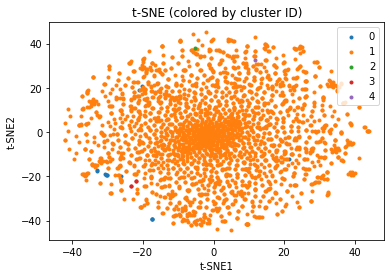

In [12]:
#plt.figure(figsize=(10,7))
plt.title("t-SNE (colored by cluster ID)")
marker = '.'
for i in range(n_cls):
    y1 = Y_tsne[ cls==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)
    
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()

#### Plot of t-SNE colored by target  

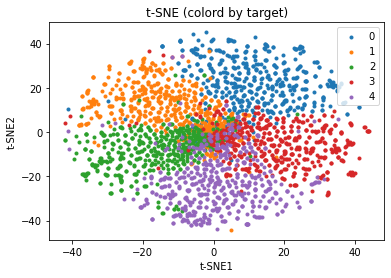

In [13]:
#plt.figure(figsize=(10,7))
plt.title("t-SNE (colord by target)")
marker = '.'
for i in range(n_cls):
    y1 = Y_tsne[ df['target']==i ]
    plt.scatter(y1[:, 0], y1[:, 1], marker=marker, label=i)
    
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.show()